In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import pickle

pd.set_option('display.max_columns', None)

In [2]:
filepath = '../data/raw/house_prices.csv'
df = pd.read_csv(filepath)

In [3]:
df.head(2)

,Index,Title,Description,Amount(in rupees),Price (in rupees),location,Carpet Area,Status,Floor,Transaction,Furnishing,facing,overlooking,Society,Bathroom,Balcony,Car Parking,Ownership,Super Area,Dimensions,Plot Area
0,0,1 BHK Ready to Occupy Flat for sale in Srushti...,"Bhiwandi, Thane has an attractive 1 BHK Flat f...",42 Lac,6000.0,thane,500 sqft,Ready to Move,10 out of 11,Resale,Unfurnished,NaN,NaN,Srushti Siddhi Mangal Murti Complex,1,2,NaN,NaN,NaN,NaN,NaN
1,1,2 BHK Ready to Occupy Flat for sale in Dosti V...,One can find this stunning 2 BHK flat for sale...,98 Lac,13799.0,thane,473 sqft,Ready to Move,3 out of 22,Resale,Semi-Furnished,East,Garden/Park,Dosti Vihar,2,NaN,1 Open,Freehold,NaN,NaN,NaN


In [4]:
def data_cleaning(input_file_path):
    # Read data
    df = pd.read_csv(input_file_path)

    # Drop the 'Index' column
    df.drop(columns=['Index', 'Dimensions', 'Plot Area'], inplace=True)

    # Drop columns with more that 30% missing values
    threshold = len(df) * 0.3
    df.dropna(thresh=threshold, axis=1, inplace=True)

    ############################## Helper Functions ##############################
    def convert_amount(amount):
        """Convert 'Amount(in rupees)' from string to numeric value."""
        if pd.isna(amount):
            return None
        # If the amount is already a numeric type, return it as float
        if isinstance(amount, (int, float)):
            return float(amount)
        # If the amount is a string, process it
        if isinstance(amount, str):
            amount = amount.strip()
            if amount == 'Call for Price':
                return None
            if 'Lac' in amount:
                try:
                    return float(amount.replace(' Lac', '').replace(',', '')) * 100000
                except ValueError:
                    return None
            if 'Cr' in amount:
                try:
                    return float(amount.replace(' Cr', '').replace(',', '')) * 10000000
                except ValueError:
                    return None
            # Handle plain numeric strings
            try:
                return float(amount.replace(',', ''))
            except ValueError:
                return None
        # For any other data type, return None
        return None

    def convert_area(area):
        """Convert area-related columns from string to numeric value."""
        if pd.isna(area):
            return None
        # If the area is already a numeric type, return it as float
        if isinstance(area, (int, float)):
            return float(area)
        # If the area is a string, process it
        if isinstance(area, str):
            area = area.strip()
            try:
                return float(area.replace(' sqft', '').replace(',', ''))
            except ValueError:
                return None
        # For any other data type, return None
        return None
        
    ############################## Helper Functions ##############################

    # Convert 'Amount(in rupees)' to numeric
    df['Amount(in rupees)'] = df['Amount(in rupees)'].apply(convert_amount)

    # Convert 'Carpet Area' and 'Super Area' to numeric
    df['Carpet Area'] = df['Carpet Area'].apply(convert_area)
    df['Super Area'] = df['Super Area'].apply(convert_area)

    # Impute missing values
    # Numerical columns
    df['Price (in rupees)'].fillna(df['Price (in rupees)'].median(), inplace=True)
    df['Carpet Area'].fillna(df['Carpet Area'].median(), inplace=True)
    df['Super Area'].fillna(df['Super Area'].median(), inplace=True)

    # Categorical columns
    df['Description'].fillna('No description available', inplace=True)
    df['Status'].fillna(df['Status'].mode()[0], inplace=True)
    df['Floor'].fillna(df['Floor'].mode()[0], inplace=True)
    df['Transaction'].fillna(df['Transaction'].mode()[0], inplace=True)
    df['Furnishing'].fillna(df['Furnishing'].mode()[0], inplace=True)
    df['facing'].fillna(df['facing'].mode()[0], inplace=True)
    df['overlooking'].fillna('Not Specified', inplace=True)
    df['Society'].fillna('Unknown', inplace=True)
    df['Bathroom'].fillna(df['Bathroom'].mode()[0], inplace=True)
    df['Balcony'].fillna(df['Balcony'].mode()[0], inplace=True)
    df['Car Parking'].fillna('Not Available', inplace=True)
    df['Ownership'].fillna(df['Ownership'].mode()[0], inplace=True)

    # Identify outliers using IQR method
    #Q1 = df[['Amount(in rupees)', 'Price (in rupees)', 'Carpet Area', 'Super Area']].quantile(0.25)
    #Q3 = df[['Amount(in rupees)', 'Price (in rupees)', 'Carpet Area', 'Super Area']].quantile(0.75)
    #IQR = Q3 - Q1

    # Filter out the outliers
    #df = df[~((df[['Amount(in rupees)', 'Price (in rupees)', 'Carpet Area', 'Super Area']] < (Q1 - 1.5 * IQR)) | (df[['Amount(in rupees)', 'Price (in rupees)', 'Carpet Area', 'Super Area']] > (Q3 + 1.5 * IQR))).any(axis=1)]

    lower_cap = df['Price (in rupees)'].quantile(0.01)
    upper_cap = df['Price (in rupees)'].quantile(0.99)
    df['Price (in rupees)'] = np.clip(df['Price (in rupees)'], lower_cap, upper_cap)

    return df

In [5]:
df1 = data_cleaning(filepath)

In [6]:
df1.head()

,Title,Description,Amount(in rupees),Price (in rupees),location,Carpet Area,Status,Floor,Transaction,Furnishing,facing,overlooking,Society,Bathroom,Balcony,Car Parking,Ownership,Super Area
0,1 BHK Ready to Occupy Flat for sale in Srushti...,"Bhiwandi, Thane has an attractive 1 BHK Flat f...",4200000.0,6000.0,thane,500.0,Ready to Move,10 out of 11,Resale,Unfurnished,East,Not Specified,Srushti Siddhi Mangal Murti Complex,1,2,Not Available,Freehold,1300.0
1,2 BHK Ready to Occupy Flat for sale in Dosti V...,One can find this stunning 2 BHK flat for sale...,9800000.0,13799.0,thane,473.0,Ready to Move,3 out of 22,Resale,Semi-Furnished,East,Garden/Park,Dosti Vihar,2,2,1 Open,Freehold,1300.0
2,2 BHK Ready to Occupy Flat for sale in Sunrise...,Up for immediate sale is a 2 BHK apartment in ...,14000000.0,17500.0,thane,779.0,Ready to Move,10 out of 29,Resale,Unfurnished,East,Garden/Park,Sunrise by Kalpataru,2,2,1 Covered,Freehold,1300.0
3,1 BHK Ready to Occupy Flat for sale Kasheli,This beautiful 1 BHK Flat is available for sal...,2500000.0,6034.0,thane,530.0,Ready to Move,1 out of 3,Resale,Unfurnished,East,Not Specified,Unknown,1,1,Not Available,Freehold,1300.0
4,2 BHK Ready to Occupy Flat for sale in TenX Ha...,"This lovely 2 BHK Flat in Pokhran Road, Thane ...",16000000.0,18824.0,thane,635.0,Ready to Move,20 out of 42,Resale,Unfurnished,West,"Garden/Park, Main Road",TenX Habitat Raymond Realty,2,2,1 Covered,Co-operative Society,1300.0


In [7]:
df1.shape

(187531, 18)

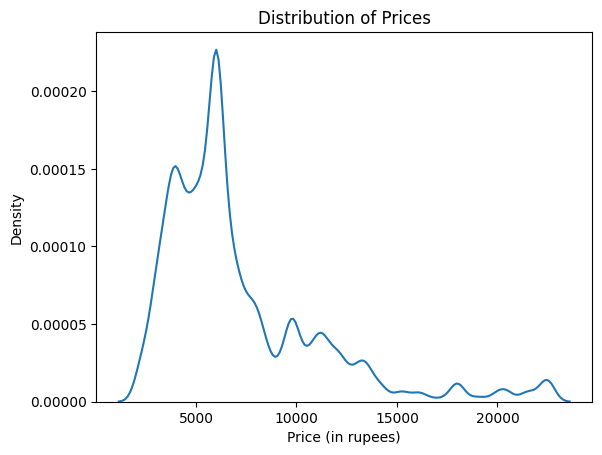

In [8]:
# Visualize distribution
sns.kdeplot(df1['Price (in rupees)'])
plt.title('Distribution of Prices')
plt.show()

In [9]:
#df1.to_csv('../data/interim/cleaned_data.csv', index=False)

In [10]:
print(df1[['location', 'Status', 'Floor', 'Transaction', 'Furnishing', 'facing', 'overlooking', 'Society', 'Bathroom', 'Balcony', 'Car Parking', 'Ownership']].nunique())

location          81
Status             1
Floor            947
Transaction        4
Furnishing         3
facing             8
overlooking       20
Society        10377
Bathroom          11
Balcony           11
Car Parking      230
Ownership          4
dtype: int64


In [11]:
def data_preprocessing(filepath_cleaned_data):
    df = pd.read_csv(filepath_cleaned_data)

    # Drop columns with a single value, and the columns 'Title' and 'Description'
    df.drop(columns=['Status', 'Title', 'Description'], inplace=True)

    # Transform the 'Floor' Column
    # Split the'Floor column into 'Current_Floor' and 'Total_Floors'
    floor_split = df['Floor'].str.split(' out of ', expand=True)
    df['Current_Floor'] = pd.to_numeric(floor_split[0], errors='coerce')
    df['Total_Floors'] = pd.to_numeric(floor_split[1], errors='coerce')

    # Create a new feature 'Floor_Ratio' as the ratio of Current_Floor to Total_Floors
    df['Floor_Ratio'] = df['Current_Floor'] / df['Total_Floors']

    # Drop the original 'Floor' column
    #df.drop(columns=['Floor'], inplace=True)

    # Handle Categorical Variables
    # One-hot encode categorical columns
    categorical_columns = ['Transaction', 'Furnishing', 'facing', 'overlooking', 'Ownership']
    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

    # Handle Unique High-Cardinality Columns
    # Frequency encoding for 'location', 'Society' and 'Car Parking'
    df['location_freq'] = df['location'].map(df['location'].value_counts())
    df['Society_freq'] = df['Society'].map(df['Society'].value_counts())
    df['Car_Parking_freq'] = df['Car Parking'].map(df['Car Parking'].value_counts())

    # Convert binary to numeric
    df = df.applymap(lambda x: 1 if x is True else (0 if x is False else x))

    # Convert 'Bathroom' and 'Balcony' columns to integers
    df['Bathroom'] = df['Bathroom'].replace('> 10', 11).astype(int)
    df['Balcony'] = df['Balcony'].replace('> 10', 11).astype(int)

    return df

filepath1 = '../data/interim/cleaned_data.csv'
data = data_preprocessing(filepath1)
data[['location', 'location_freq', 'Society', 'Society_freq', 'Car Parking', 'Car_Parking_freq']]

,location,location_freq,Society,Society_freq,Car Parking,Car_Parking_freq
0,thane,1933,Srushti Siddhi Mangal Murti Complex,1,Not Available,103357
1,thane,1933,Dosti Vihar,1,1 Open,7873
2,thane,1933,Sunrise by Kalpataru,6,1 Covered,38754
3,thane,1933,Unknown,109678,Not Available,103357
4,thane,1933,TenX Habitat Raymond Realty,6,1 Covered,38754
...,...,...,...,...,...,...
187526,zirakpur,1530,Bollywood Esencia,56,1 Covered,38754
187527,zirakpur,1530,Sushma Urban Views,6,1 Covered,38754
187528,zirakpur,1530,Bollywood Esencia,56,"1 Covered,",16991
187529,zirakpur,1530,Friends Enclave,2,Not Available,103357


In [12]:
data

,Amount(in rupees),Price (in rupees),location,Carpet Area,Floor,Society,Bathroom,Balcony,Car Parking,Super Area,Current_Floor,Total_Floors,Floor_Ratio,Transaction_Other,Transaction_Rent/Lease,Transaction_Resale,Furnishing_Semi-Furnished,Furnishing_Unfurnished,facing_North,facing_North - East,facing_North - West,facing_South,facing_South - East,facing_South -West,facing_West,"overlooking_Garden/Park, Main Road","overlooking_Garden/Park, Main Road, Pool","overlooking_Garden/Park, Not Available","overlooking_Garden/Park, Pool","overlooking_Garden/Park, Pool, Main Road","overlooking_Garden/Park, Pool, Main Road, Not Available",overlooking_Main Road,"overlooking_Main Road, Garden/Park","overlooking_Main Road, Garden/Park, Pool","overlooking_Main Road, Not Available","overlooking_Main Road, Pool","overlooking_Main Road, Pool, Garden/Park",overlooking_Not Specified,overlooking_Pool,"overlooking_Pool, Garden/Park","overlooking_Pool, Garden/Park, Main Road","overlooking_Pool, Main Road","overlooking_Pool, Main Road, Garden/Park","overlooking_Pool, Main Road, Not Available",Ownership_Freehold,Ownership_Leasehold,Ownership_Power Of Attorney,location_freq,Society_freq,Car_Parking_freq
0,4200000.0,6000.0,thane,500.0,10 out of 11,Srushti Siddhi Mangal Murti Complex,1,2,Not Available,1300.0,10.0,11.0,0.909091,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1933,1,103357
1,9800000.0,13799.0,thane,473.0,3 out of 22,Dosti Vihar,2,2,1 Open,1300.0,3.0,22.0,0.136364,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1933,1,7873
2,14000000.0,17500.0,thane,779.0,10 out of 29,Sunrise by Kalpataru,2,2,1 Covered,1300.0,10.0,29.0,0.344828,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1933,6,38754
3,2500000.0,6034.0,thane,530.0,1 out of 3,Unknown,1,1,Not Available,1300.0,1.0,3.0,0.333333,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1933,109678,103357
4,16000000.0,18824.0,thane,635.0,20 out of 42,TenX Habitat Raymond Realty,2,2,1 Covered,1300.0,20.0,42.0,0.476190,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1933,6,38754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187526,6300000.0,3225.0,zirakpur,1071.0,2 out of 4,Bollywood Esencia,3,3,1 Covered,1953.0,2.0,4.0,0.500000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1530,56,38754
187527,5500000.0,3274.0,zirakpur,1071.0,4 out of 6,Sushma Urban Views,3,2,1 Covered,1680.0,4.0,6.0,0.666667,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1530,6,38754
187528,7600000.0,4343.0,zirakpur,1250.0,1 out of 3,Bollywood Esencia,3,2,"1 Covered,",1300.0,1.0,3.0,0.333333,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1530,56,16991
187529,3000000.0,4231.0,zirakpur,1071.0,2 out of 2,Friends Enclave,2,2,Not Available,709.0,2.0,2.0,1.000000,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1530,2,103357


In [13]:
# Create the frequency mappings
location_freq_mapping = data['location'].value_counts().to_dict()
society_freq_mapping = data['Society'].value_counts().to_dict()
car_parking_mapping = data['Car Parking'].value_counts().to_dict()

# Save frequency mappings
pd.DataFrame(list(location_freq_mapping.items()), columns=['location', 'frequency']).to_csv('../data/interim/location_freq_mapping.csv', index=False)
pd.DataFrame(list(society_freq_mapping.items()), columns=['Society', 'frequency']).to_csv('../data/interim/society_freq_mapping.csv', index=False)
pd.DataFrame(list(car_parking_mapping.items()), columns=['Car Parking', 'frequency']).to_csv('../data/interim/car_parking_freq_mapping.csv', index=False)

In [14]:
# Drop columns
data.drop(columns=['Floor', 'location', 'Society', 'Car Parking'], inplace=True)

In [15]:
# Handle any remaining missing values
data.fillna(data.median(), inplace=True)

# Feature scaling
scaler = StandardScaler()
columns = list(data.columns)
columns.remove('Price (in rupees)')
columns.remove('Amount(in rupees)')
data[columns] = scaler.fit_transform(data[columns])

In [16]:
data

,Amount(in rupees),Price (in rupees),Carpet Area,Bathroom,Balcony,Super Area,Current_Floor,Total_Floors,Floor_Ratio,Transaction_Other,Transaction_Rent/Lease,Transaction_Resale,Furnishing_Semi-Furnished,Furnishing_Unfurnished,facing_North,facing_North - East,facing_North - West,facing_South,facing_South - East,facing_South -West,facing_West,"overlooking_Garden/Park, Main Road","overlooking_Garden/Park, Main Road, Pool","overlooking_Garden/Park, Not Available","overlooking_Garden/Park, Pool","overlooking_Garden/Park, Pool, Main Road","overlooking_Garden/Park, Pool, Main Road, Not Available",overlooking_Main Road,"overlooking_Main Road, Garden/Park","overlooking_Main Road, Garden/Park, Pool","overlooking_Main Road, Not Available","overlooking_Main Road, Pool","overlooking_Main Road, Pool, Garden/Park",overlooking_Not Specified,overlooking_Pool,"overlooking_Pool, Garden/Park","overlooking_Pool, Garden/Park, Main Road","overlooking_Pool, Main Road","overlooking_Pool, Main Road, Garden/Park","overlooking_Pool, Main Road, Not Available",Ownership_Freehold,Ownership_Leasehold,Ownership_Power Of Attorney,location_freq,Society_freq,Car_Parking_freq
0,4200000.0,6000.0,-0.295263,-1.640163,-0.001599,-0.072239,1.219708,0.320028,1.374794,-0.061604,-0.003266,0.547719,-0.973159,1.209348,-0.310943,-0.385105,-0.144642,-0.160228,-0.11908,-0.105673,-0.218886,-0.412221,-0.014423,-0.002309,-0.124888,-0.26624,-0.002309,-0.455242,-0.0597,-0.085438,-0.004618,-0.007659,-0.006532,1.141404,-0.073659,-0.048218,-0.140199,-0.078068,-0.005656,-0.002309,0.234628,-0.170292,-0.075717,-1.358704,-1.194688,0.876342
1,9800000.0,13799.0,-0.307042,-0.490266,-0.001599,-0.072239,-0.348577,1.782507,-1.653879,-0.061604,-0.003266,0.547719,1.027581,-0.826892,-0.310943,-0.385105,-0.144642,-0.160228,-0.11908,-0.105673,-0.218886,-0.412221,-0.014423,-0.002309,-0.124888,-0.26624,-0.002309,-0.455242,-0.0597,-0.085438,-0.004618,-0.007659,-0.006532,-0.876114,-0.073659,-0.048218,-0.140199,-0.078068,-0.005656,-0.002309,0.234628,-0.170292,-0.075717,-1.358704,-1.194688,-1.462531
2,14000000.0,17500.0,-0.173542,-0.490266,-0.001599,-0.072239,1.219708,2.713175,-0.836813,-0.061604,-0.003266,0.547719,-0.973159,1.209348,-0.310943,-0.385105,-0.144642,-0.160228,-0.11908,-0.105673,-0.218886,-0.412221,-0.014423,-0.002309,-0.124888,-0.26624,-0.002309,-0.455242,-0.0597,-0.085438,-0.004618,-0.007659,-0.006532,-0.876114,-0.073659,-0.048218,-0.140199,-0.078068,-0.005656,-0.002309,0.234628,-0.170292,-0.075717,-1.358704,-1.194595,-0.706103
3,2500000.0,6034.0,-0.282175,-1.640163,-1.215708,-0.072239,-0.796658,-0.743593,-0.881864,-0.061604,-0.003266,0.547719,-0.973159,1.209348,-0.310943,-0.385105,-0.144642,-0.160228,-0.11908,-0.105673,-0.218886,-0.412221,-0.014423,-0.002309,-0.124888,-0.26624,-0.002309,-0.455242,-0.0597,-0.085438,-0.004618,-0.007659,-0.006532,1.141404,-0.073659,-0.048218,-0.140199,-0.078068,-0.005656,-0.002309,0.234628,-0.170292,-0.075717,-1.358704,0.842506,0.876342
4,16000000.0,18824.0,-0.236366,-0.490266,-0.001599,-0.072239,3.460114,4.441559,-0.321941,-0.061604,-0.003266,0.547719,-0.973159,1.209348,-0.310943,-0.385105,-0.144642,-0.160228,-0.11908,-0.105673,4.568594,2.425882,-0.014423,-0.002309,-0.124888,-0.26624,-0.002309,-0.455242,-0.0597,-0.085438,-0.004618,-0.007659,-0.006532,-0.876114,-0.073659,-0.048218,-0.140199,-0.078068,-0.005656,-0.002309,-4.262059,-0.170292,-0.075717,-1.358704,-1.194595,-0.706103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187526,6300000.0,3225.0,-0.046149,0.659632,1.212510,1.297011,-0.572618,-0.610640,-0.228621,-0.061604,-0.003266,-1.825752,1.027581,-0.826892,-0.310943,-0.385105,-0.144642,-0.160228,-0.11908,-0.105673,-0.218886,-0.412221,-0.014423,-0.002309,-0.124888,-0.26624,-0.002309,-0.455242,-0.0597,-0.085438,-0.004618,-0.007659,-0.006532,-0.876114,-0.073659,-0.048218,-0.140199,-0.078068,-0.005656,-0.002309,0.234628

In [17]:
# Scale the 'Price (in rupees)'
data['Price_log'] = np.log1p(data['Price (in rupees)'])

In [18]:
data

,Amount(in rupees),Price (in rupees),Carpet Area,Bathroom,Balcony,Super Area,Current_Floor,Total_Floors,Floor_Ratio,Transaction_Other,Transaction_Rent/Lease,Transaction_Resale,Furnishing_Semi-Furnished,Furnishing_Unfurnished,facing_North,facing_North - East,facing_North - West,facing_South,facing_South - East,facing_South -West,facing_West,"overlooking_Garden/Park, Main Road","overlooking_Garden/Park, Main Road, Pool","overlooking_Garden/Park, Not Available","overlooking_Garden/Park, Pool","overlooking_Garden/Park, Pool, Main Road","overlooking_Garden/Park, Pool, Main Road, Not Available",overlooking_Main Road,"overlooking_Main Road, Garden/Park","overlooking_Main Road, Garden/Park, Pool","overlooking_Main Road, Not Available","overlooking_Main Road, Pool","overlooking_Main Road, Pool, Garden/Park",overlooking_Not Specified,overlooking_Pool,"overlooking_Pool, Garden/Park","overlooking_Pool, Garden/Park, Main Road","overlooking_Pool, Main Road","overlooking_Pool, Main Road, Garden/Park","overlooking_Pool, Main Road, Not Available",Ownership_Freehold,Ownership_Leasehold,Ownership_Power Of Attorney,location_freq,Society_freq,Car_Parking_freq,Price_log
0,4200000.0,6000.0,-0.295263,-1.640163,-0.001599,-0.072239,1.219708,0.320028,1.374794,-0.061604,-0.003266,0.547719,-0.973159,1.209348,-0.310943,-0.385105,-0.144642,-0.160228,-0.11908,-0.105673,-0.218886,-0.412221,-0.014423,-0.002309,-0.124888,-0.26624,-0.002309,-0.455242,-0.0597,-0.085438,-0.004618,-0.007659,-0.006532,1.141404,-0.073659,-0.048218,-0.140199,-0.078068,-0.005656,-0.002309,0.234628,-0.170292,-0.075717,-1.358704,-1.194688,0.876342,8.699681
1,9800000.0,13799.0,-0.307042,-0.490266,-0.001599,-0.072239,-0.348577,1.782507,-1.653879,-0.061604,-0.003266,0.547719,1.027581,-0.826892,-0.310943,-0.385105,-0.144642,-0.160228,-0.11908,-0.105673,-0.218886,-0.412221,-0.014423,-0.002309,-0.124888,-0.26624,-0.002309,-0.455242,-0.0597,-0.085438,-0.004618,-0.007659,-0.006532,-0.876114,-0.073659,-0.048218,-0.140199,-0.078068,-0.005656,-0.002309,0.234628,-0.170292,-0.075717,-1.358704,-1.194688,-1.462531,9.532424
2,14000000.0,17500.0,-0.173542,-0.490266,-0.001599,-0.072239,1.219708,2.713175,-0.836813,-0.061604,-0.003266,0.547719,-0.973159,1.209348,-0.310943,-0.385105,-0.144642,-0.160228,-0.11908,-0.105673,-0.218886,-0.412221,-0.014423,-0.002309,-0.124888,-0.26624,-0.002309,-0.455242,-0.0597,-0.085438,-0.004618,-0.007659,-0.006532,-0.876114,-0.073659,-0.048218,-0.140199,-0.078068,-0.005656,-0.002309,0.234628,-0.170292,-0.075717,-1.358704,-1.194595,-0.706103,9.770013
3,2500000.0,6034.0,-0.282175,-1.640163,-1.215708,-0.072239,-0.796658,-0.743593,-0.881864,-0.061604,-0.003266,0.547719,-0.973159,1.209348,-0.310943,-0.385105,-0.144642,-0.160228,-0.11908,-0.105673,-0.218886,-0.412221,-0.014423,-0.002309,-0.124888,-0.26624,-0.002309,-0.455242,-0.0597,-0.085438,-0.004618,-0.007659,-0.006532,1.141404,-0.073659,-0.048218,-0.140199,-0.078068,-0.005656,-0.002309,0.234628,-0.170292,-0.075717,-1.358704,0.842506,0.876342,8.705331
4,16000000.0,18824.0,-0.236366,-0.490266,-0.001599,-0.072239,3.460114,4.441559,-0.321941,-0.061604,-0.003266,0.547719,-0.973159,1.209348,-0.310943,-0.385105,-0.144642,-0.160228,-0.11908,-0.105673,4.568594,2.425882,-0.014423,-0.002309,-0.124888,-0.26624,-0.002309,-0.455242,-0.0597,-0.085438,-0.004618,-0.007659,-0.006532,-0.876114,-0.073659,-0.048218,-0.140199,-0.078068,-0.005656,-0.002309,-4.262059,-0.170292,-0.075717,-1.358704,-1.194595,-0.706103,9.842941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187526,6300000.0,3225.0,-0.046149,0.659632,1.212510,1.297011,-0.572618,-0.610640,-0.228621,-0.061604,-0.003266,-1.825752,1.027581,-0.826892,-0.310943,-0.385105,-0.144642,-0.160228,-0.11908,-0.105673,-0.218886,-0.412221,-0.014423,-0.002309,-0.124888,-0.26624,-0.002309,-0.455242,-0.0597,-0.085438,-0.004618,-0.007659,-0.006532,-0.876114,-0.073659

In [19]:
# Save the scaler
with open('../models/standard_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [20]:
# Save processed data
data.to_csv('../data/processed/processed_data.csv', index=False)

# 1. **Data Cleaning:**

1. **Reading and Initial Cleanup:**

- **Load Data:** The data is read from a CSV file.

- **Drop Columns:** The 'Index', 'Dimensions', and 'Plot Area' columns are dropped, as well as any columns with more than 30% missing values.

2. **Helper Functions:**

- **`convert_amount`**: Converts the 'Amount (in rupees)' column from strings (e.g., "Lac", "Cr") to numeric values.

- **`convert_area`**: Converts area-related columns (e.g., 'Carpet Area', 'Super Area') from strings to numeric values.

3. **Conversion:**

- **Amount Conversion**: Apply convert_amount to 'Amount (in rupees)'.

- **Area Conversion**: Apply convert_area to 'Carpet Area' and 'Super Area'.

4. **Missing Values Imputation:**

- **Numerical Columns**: Missing values in 'Price (in rupees)', 'Carpet Area', and 'Super Area' are imputed with the median.

- **Categorical Columns**: Missing values in various categorical columns (e.g., 'Description', 'Status', 'Floor', etc.) are filled with appropriate default values or the mode.

5. **Outlier Treatment:**

- **Outlier Clipping:** For 'Price (in rupees)', values are clipped to the 1st and 99th percentiles.

# 2. Data Preprocessing:

1. **Column Management:**

- **Drop Single-Value Columns**: Columns with a single value and 'Title' and 'Description' are dropped.

2. **Feature Engineering:**

- **Floor Column Transformation**:
    - Split the 'Floor' column into 'Current_Floor' and 'Total_Floors'.
    - Create a new feature, 'Floor_Ratio', as the ratio of 'Current_Floor' to 'Total_Floors'.

3. **Categorical Variable Handling:**

- One-Hot Encoding: Convert categorical columns (e.g., 'Transaction', 'Furnishing', etc.) into one-hot encoded features.

4. **High-Cardinality Columns Handling:**

- **Frequency Encoding**: 'location', 'Society', and 'Car Parking' columns are frequency-encoded, creating new columns for their respective frequencies.

5. **Binary Conversion:**

- Convert boolean values in the dataset to numeric (1 for True, 0 for False).

6. **Integer Conversion:**

- **Bathroom & Balcony Columns**: Convert the 'Bathroom' and 'Balcony' columns to integers, handling the '> 10' case by replacing it with 11.

# 3. **Saving Frequency Mappings:**

- **Export Frequency Mappings:** Save the frequency mappings for 'location', 'Society', and 'Car Parking' columns into separate CSV files for future reference.

# 4. **Feature Scaling:**

1. **Apply Standard Scaler:**

- Scale all columns except 'Price (in rupees)' using StandardScaler.
- Log Transformation: Apply log transformation to 'Price (in rupees)', creating a new column 'Price_log'.

2. **Save Scaler:**

- The scaler object is saved as a .pkl file for future use during model deployment and single predictions.
